In [8]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        #ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

def s(im):
    plt.figure()
    plt.imshow(im)
def ss(ar):
    print(ar.shape)
def sss(im):
    
    fig, ax = plt.subplots(1, 1)

    tracker = IndexTracker(ax, im)

    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()

In [1]:
%pylab nbagg
%load_ext autoreload

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

# phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
#              'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_hard =  ['air','water','water','water',
             'water','water','water','water']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO']#,'CuGOS_lowres']

phan_maps = [phan_map_hard]#,phan_map_soft]

angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_515(os.path.join(xg.data_path,f'phantoms/{geo}.npy'))

In [4]:
phantom.phantom = np.zeros([10,1024,1024]) #

In [5]:
for phan_map in phan_maps:
    for spectrum_file in spectrum_files:
        for det in dets:
            s = xg.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))
            
            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = xg.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

            dump_files = os.path.join(
                xg.data_path, "Detectors", det, '*phsp.npy')
            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

            kernel, kernels = xg.get_kernel(
                                    s, dump_files, energy_deposition_file)

            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            noise = xg.update_fluence(spectrum_file,dose)

            res.append(xg.return_projs(phantom.phantom,kernel,
                                       energies,fluence,angles,phantom.geomet,
                                       deposition_efficiency_file=deposition_efficiency_file
                                       ,phantom_mapping = phan_map,
                                       scaling=noise,
                                      dose=dose))

#             img_xg = tigre.algorithms.FDK(
#                 np.transpose(np.array(projs_xg[0]),[0,2,1]), phantom.geomet,angles)

#             res.append([[phan_map,spectrum_file,det],phantom.analyse_515(img_xg[5])])

(17,) (17,)
0.0006164371355334828


../xpecgen/xpecgen.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  scaling = (dose)/dose_in_mgrays


Scaled by  inf


KeyboardInterrupt: 

In [39]:
def create_circular_mask(x, y, r, index, image):
    
    h,w = image.shape
    
    center = [x*int(w/2)/8 + int(w/2),y*int(h/2)/8 + int(h/2)]

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if r is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= r*int(w/2)/8
    
    
    image[mask] = index
    
def create_block(x, y, r, index,n, image):

    h,w = im.shape

    center = np.round([x*int(w/2)/8 + int(w/2),y*int(h/2)/8 + int(h/2)]).astype(int)

    len = 50
    g = r

    plus = int(center[0] + int((n-1)*g/2))
    minus = int(center[1] - int((n-1)*g/2))

    for ii in range(center[0], center[0] + int(2*g)*n, int(2*g)):

        im[center[1]:center[1]+len,ii:ii+g] = index


im = np.zeros([1024,1024])
#im = np.zeros([256,256])
ii = 1

# CTMAT(x) formel=H2O dichte=x
LEN = 100

A0  = 87.7082*np.pi/180
A1 = 108.3346*np.pi/180
A2 = 126.6693*np.pi/180
A3 = 142.7121*np.pi/180
A4 = 156.4631*np.pi/180
A5 = 167.9223*np.pi/180
A6 = 177.0896*np.pi/180
A7 = 183.9651*np.pi/180
A8 = 188.5487*np.pi/180

B0 = 110.6265*np.pi/180
B1 = 142.7121*np.pi/180
B2 = 165.6304*np.pi/180
B3 = 179.3814*np.pi/180

# Phantom 
# ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
create_circular_mask(x= 0.000,  y= 0.000,  r=8.0, index = ii, image = im)

ii += 1

# ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= 2,  r=1, n=20, index = ii, image = im)
create_block(x= -1,  y= 2,  r=2, n=16, index = ii, image = im)
create_block(x= 1,  y= 2,  r=3, n=10, index = ii, image = im)
create_block(x= 3,  y= 2,  r=4, n=10, index = ii, image = im)

# ++++ supra-slice 0.3% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= 0,  r=5, n=6, index = ii, image = im)
create_block(x= -1,  y= 0,  r=6, n=6, index = ii, image = im)
create_block(x=1,  y= 0,  r=7, n=5, index = ii, image = im)
create_block(x= 3,  y= 0,  r=8, n=4, index = ii, image = im)


# ++++ supra-slice 1% targets +++++++++++++++++++++++++++++++++++++++ */
create_block(x= -3,  y= -2,  r=9, n=4, index = ii, image = im)
create_block(x= -1,  y= -2, r=10, n=4, index = ii, image = im)
create_block(x= 1,  y= -2,  r=11, n=3, index = ii, image = im)
create_block(x= 3,  y= -2,  r=14, n=2, index = ii, image = im)


<IPython.core.display.Javascript object>


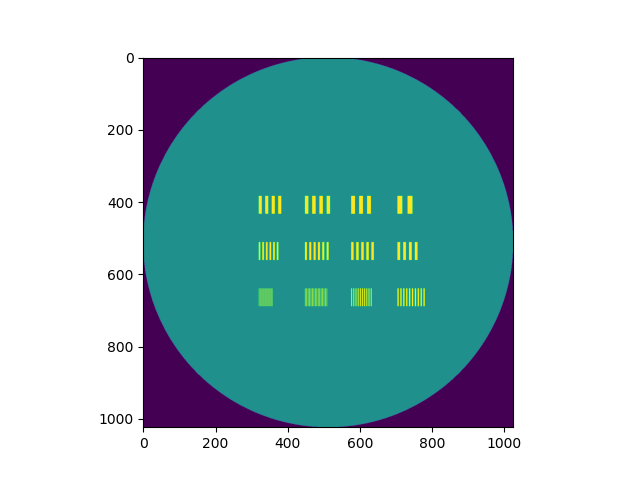

In [40]:
s(im)

In [41]:
im_stack = np.tile(im,[10,1,1])

In [42]:
np.save('Contrast_phantom_1024',im_stack)

In [55]:
            x = np.linspace(0.5,512,512,endpoint=False)
            xf = np.linspace(0.25,512,1024,endpoint=False)

In [58]:
np.interp()

TypeError: _interp_dispatcher() missing 3 required positional arguments: 'x', 'xp', and 'fp'

<IPython.core.display.Javascript object>


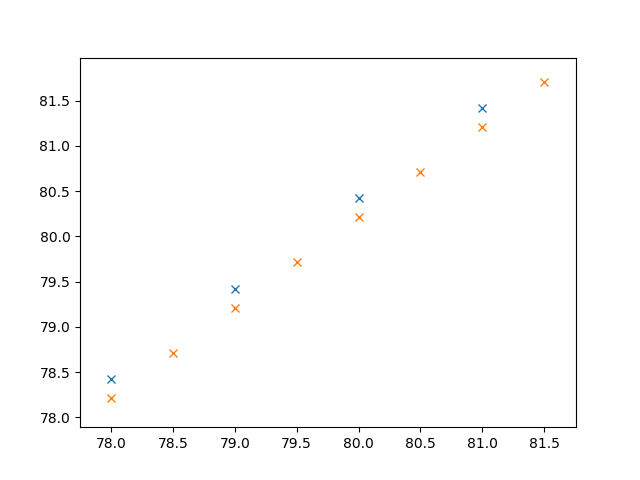

In [57]:
plt.figure()
plt.plot(np.arange(512),x,'x')
plt.plot(np.arange(0,512,0.5),xf,'x')